# DSCI 100 Proposal

**Research question:** How accurately can we diagnose chest pain (categorised as typical angina, non-typical angina, asymptomatic) for Swiss patients based on their resting heart rate and blood pressure?

## Introduction

Chest pain encompasses discomfort such as tightness, pressure, or fullness in the chest region. This study focuses on Angina, a type of chest pain linked to coronary heart disease, resulting from insufficient blood supply to the heart due to irregular blood pressure and/or heart rate. Angina is classified into typical and non-typical forms, with typical angina exhibiting predictable pain lasting up to 10 minutes, while non-typical angina lacks a discernible pattern. Recognizing these variations is vital for prescribing suitable medication and evaluating the condition's severity, particularly to distinguish it from potential heart attacks. Thus, our research aims to determine the best recall for diagnosing chest pain (classified as typical angina, non-typical angina, and asymptomatic chest pain) in Hungarian patients based on their resting heart rate and blood pressure. We prioritize recall over precision because patients with rare cases of Angina must be diagnosed and properly treated, as it can be life-saving. To address our inquiry we will analyze a dataset containing health records of a specified sample size of Hungarian patients, categorizing their chest pain as anginal, non-anginal and asymptomatic chest pain based on observed resting heart rate and blood pressure.

## Preliminary exploratory data analysis

### Reading and wrangling data

After downloading the folder from the archive and storing it in a folder named "data", we read the “processed_switzerland.data” file (read_csv as it uses commas as its separator). We mutate the variable cp (chest pain) as a factor, recode its values to their respective chest pain types, and convert our two main variables into doubles (trestbps and thalrest; removed missing cases from trestbps). Note that our data is already tidy, so no wrangling was needed.

In [6]:
install.packages("themis")

library(tidyverse)
library(repr)
library(tidymodels)
library(themis)

also installing the dependencies ‘RANN’, ‘ROSE’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [7]:
heart_disease <- read_csv("data/processed.hungarian.data",
                            col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalrest", 
                                          "exang", "oldpeak", "slope", "ca", "thal", "num")) |>
# cp       -> chest pain
# trestbps -> resting blood pressure
# thalach  -> max heart rate achieved
    mutate(cp = as_factor(cp)) |>
    mutate(cp = fct_recode(cp, "typical_angina" = "1", "atypical_angina" = "2", "non_anginal" = "3", "asymptomatic" = "4")) |>
    filter(cp != "non_anginal") |> #We will not cover non_anginal chest pains.
    mutate(trestbps = as.numeric(trestbps),
           thalrest = as.numeric(thalrest)) |>
    filter(trestbps != "NA") |>
    select(cp, trestbps, thalrest)

#drop the non_anginal factor
heart_disease$cp <- fct_drop(heart_disease$cp)

heart_disease

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, chol, fbs, restecg, thalrest, exang, slope, ca, thal
dbl (5): age, sex, cp, oldpeak, num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `trestbps = as.numeric(trestbps)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


cp,trestbps,thalrest
<fct>,<dbl>,<dbl>
atypical_angina,130,185
atypical_angina,120,160
atypical_angina,140,170
typical_angina,170,170
atypical_angina,100,150
atypical_angina,105,165
atypical_angina,110,184
atypical_angina,125,155
atypical_angina,130,190


*Figure 1: Our tidy dataset. Lists types of angina, resting blood pressure (mm Hg) and maximum heart rate (bpm)*

### Summarizing data

We split the data, and compute a few relevant statistics of our data, such as: average resting heart rate, average blood pressure, counts, and the percentage of each type of chest pain.

In [8]:
#set the seed to make our splits consistent, and thereby reproducible
set.seed(2)

#splitting the data for later cross-validation
heart_disease_split <- initial_split(heart_disease, prop = 0.75, strata = cp)
heart_training <- training(heart_disease_split)
heart_testing <- testing(heart_disease_split)

#summarizing training data
heart_disease_summary <- heart_training |>
    group_by(cp) |>
    summarise(avg_trestbps = mean(trestbps),
              avg_thalrest = mean(thalrest),
              count = n(),
              percent = 100 * n() / nrow(heart_training))
heart_disease_summary

cp,avg_trestbps,avg_thalrest,count,percent
<fct>,<dbl>,<dbl>,<int>,<dbl>
typical_angina,132.2222,147.4444,9,5.05618
atypical_angina,130.3205,147.1538,78,43.82022
asymptomatic,135.1429,129.3407,91,51.12360


*Figure 2: Statistical analysis of dataset*

### Visualization 

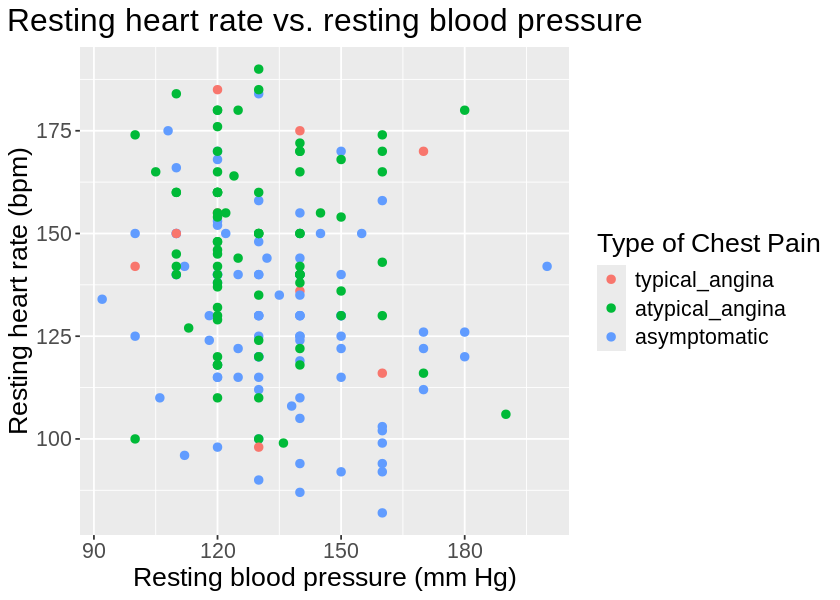

In [9]:
options(repr.plot.width = 7, repr.plot.height = 5)
heart_disease_viz <- heart_training |>
 ggplot(aes(x = trestbps, y = thalrest, colour = cp)) + 
 geom_point(size = 2) +
 ggtitle("Resting heart rate vs. resting blood pressure") +
 theme(text = element_text(size = 16), plot.title = element_text(size = 19, hjust = 0.5)) +
 labs(x = "Resting blood pressure (mm Hg)", y = "Resting heart rate (bpm)",
      color = "Type of Chest Pain")

heart_disease_viz

*Figure 3: Visualisation of data, colour-coded by chest pain.*

Now, we create use the k-nearest neighbours engine to develop a classification model. In this model, we will use resting blood pressure and resting heart rate as our prediction variables, and chest pain (typical, atypical and asymptomatic) as our prediction variable. We must tune this model using cross-validation and find whichever k-value will yield the highest accuracy. To do this, we choose k-values from 1 to 100, jumping by increments of 5. Finally, we print the best k-value along with a scatter plot of accuracy vs. k-value.

[1] 91

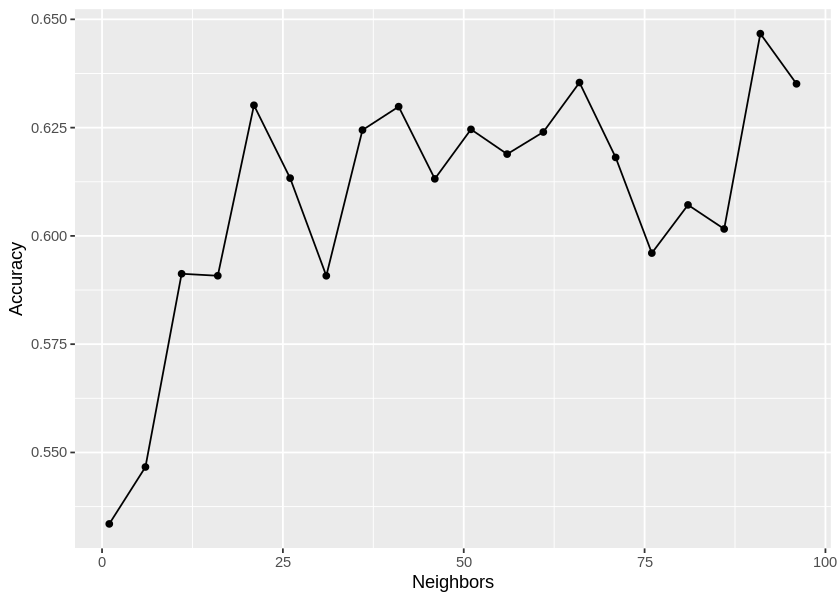

In [5]:
set.seed(5)

heart_recipe <- recipe(cp ~ trestbps + thalrest, data = heart_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

heart_spec_tuning <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

vfolds <- vfold_cv(heart_training, v = 5, strata = cp)
k_vals <- tibble(neighbors = seq(from =  1, to = 100, by = 5))

knn_results <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec_tuning) |>
    tune_grid(resamples = vfolds, grid = k_vals) |>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == "accuracy")

tuning_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy")
tuning_plot

best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

*Figure 4: Plotting our estimated accuracy for each k-value*

Now that we've identified the most accurate k-value, we create a new classification model that uses k = 91 as the nearest neighbours. 

In [6]:
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec) |>
    fit(data = heart_training)

Finally, we can analyze the metrics of our tuned classification model. We can do this by creating a confusion matrix, and calculating the accuracy and recall. As a reminder, we are interested in seeing how accurately our model can predict types of Angina from resting blood pressure and maximum heart rate. In this process we wish to prioritize a higher recall over higher accuracy, as angina is linked to coronary heart disease which can be fatal. Thus, a false diagnosis is much less troublesome than a missed diagnosis.

In [7]:
heart_predictions <- predict(heart_fit, heart_testing) |>
    bind_cols(heart_testing)

# Confusion Matrix
heart_mat <- heart_predictions |>
    conf_mat(truth = cp, estimate = .pred_class)

# Gathers the values from the confusion matrix and stores them as a data frame
conf_mat_vals <- do.call(rbind.data.frame, heart_mat) |>
    pivot_wider(names_from = Truth, values_from = Freq)
conf_mat_vals

# Accuracy
heart_predictions |>
    metrics(truth = cp, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(!.estimator)

# Recall for typical_angina
typical_alltruths <- conf_mat_vals |>
    summarise(sum(typical_angina)) |>
    pull()
typical_true_positive <- conf_mat_vals |>
    filter(Prediction == "typical_angina") |>
    select(typical_angina) |>
    pull()

# Recall for atypical_angina
atypical_alltruths <- conf_mat_vals |>
    summarise(sum(atypical_angina)) |>
    pull()
atypical_true_positive <- conf_mat_vals |>
    filter(Prediction == "atypical_angina") |>
    select(atypical_angina) |>
    pull()

recall_summary <- tibble(typical_angina = c(typical_true_positive / typical_alltruths), 
                         atypical_angina = c(atypical_true_positive / atypical_alltruths))
recall_summary

Prediction,typical_angina,atypical_angina,asymptomatic
<chr>,<dbl>,<dbl>,<dbl>
typical_angina,0,0,0
atypical_angina,1,20,5
asymptomatic,1,7,27


.metric,.estimate
<chr>,<dbl>
accuracy,0.7704918


typical_angina,atypical_angina
<dbl>,<dbl>
0,0.7407407


*Figure 5, 6 and 7: (in order) Confusion matrix of our tuned classification model, accuracy of our model, and the recall for typical and atypical Angina.*

In Figure 6 and 7 we see that our classification model has an accuracy of 77.05%, and we have a recall of 0% (typical Angina,) and 74% (atypical Angina.) Most notably, our classification model has a 0% recall for typical angina. In fact, if we look at Figure 5 we can see that our model was not able to predict any data as typical Angina at all. We can also observe from Figure 5 that our testing data set only has two chest pain observations that were actually typical Angina. Due to this small amount of data, it is unlikely that any new observation is close in distance to typical Angina data points compared to atypical or asymptomatic.  the nature of k-nearest neighbours classification, this means that 

## Methods

We will use the k-nn classification to create a model that predicts the type of chest pain (atypical angina, typical angina, or asymptomatic) of a random observation using two predictors: resting heart rate and blood pressure. Due to smaller number of typical and atypical angina, we will have to use oversampling to resolve the class imbalance. Next, we will tune our model for the best number of neighbors using the standard tuning procedure and a scatterplot of the number of neighbors against vs estimated recall (possibly another graph plotting the number of neighbors vs estimated accuracy). We will also be applying some other statistical measures such as accuracy and precision. Finally, we will re-plot resting heart rate vs. resting blood pressure with new real observations to visualize how our model predicts them, and give a qualitative assesment of our model's overall performance.

**Variables:** 

- *Prediction Variable*: Typical angina, non-typical angina, or asymptomatic 
- *Observation Variable 1*: Resting Blood pressure
- *Observation Variable 2*: Resting Heart rate

## Expected outcomes and significance

The classifier will predict the type of chest pain based on a range: 
- Heart rate <60, blood pressure >140/90 mm Hg, means non-typical
- Heart rate >120, blood pressure >140/90 mm Hg, means typical 
- Heart rate between 60-120, blood pressure >140/90 mm Hg, means asymptomatic

Being able to properly diagnose the type of chest pain a patient has based on heart rate and blood pressure is significant because it makes their pain measurable. Proper identification of the type of chest pain gives healthcare workers the ability to efficiently treat patients with the proper medication and can also reveal possible future risks of more serious cardiovascular issues. Knowing these risks can help patients and doctors plan accordingly. 

*Sources: UpToDate. (2024). Uptodate.com. https://www.uptodate.com/contents/chest-pain-beyond-the-basics. 
 In-text citation: (UpToDate, 2024)*